In [1]:
THEO_COLUMNS = ['theo_event_tx_timestamp', 'theo_event_tx_timestamp_ns',
                'instrument_hash','tv','delta','vol','vega','under','tte',
                'option_type_name','inst_type_name','strike','term']

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('./grad_data_2023.csv')

In [4]:
from enum import Enum, auto

In [5]:
class Frequency(str, Enum):
    SNAP = 'snap'
    MINUTE = 'minute'
    HOURLY = 'hour'
    DAILY = 'daily'

In [6]:
class Hedger:

    def __init__(self,
                 data: pd.DataFrame,
                 t_cost: float = 5.0,
                 open_time: str = '13:05',
                 close_time: str = '20:50',
                 # in basis point
                 ):

        self.data = data.copy()
        self.t_cost = t_cost
        self.open_time = open_time
        self.close_time = close_time
        self.prepare_data()

    def prepare_data(self):
        self.data.set_index(pd.DatetimeIndex(self.data['theo_event_tx_timestamp']), inplace=True)
        self.data.sort_index(inplace=True)
        self.data = self.data.between_time(self.open_time, self.close_time)
        self.data['id'] = range(self.data.shape[0])

    def tag_hedge_flags(self, frequency: Frequency):
        if frequency == Frequency.SNAP:
            self.data['hedge_flag'] = True
        else:
            if frequency == Frequency.MINUTE:
                grouper = pd.to_datetime(self.data.index).floor("min")
            elif frequency == Frequency.HOURLY:
                grouper = pd.to_datetime(self.data.index).floor("H")
            elif frequency == Frequency.DAILY:
                grouper = pd.to_datetime(self.data.index).date
            self.data['hedge_flag'] = self.data.groupby(grouper)['id'].transform('last') == self.data.id

    
    def _calculate_net_cash(self, prev_delta, new_delta, under):
        if new_delta > prev_delta:
            # buy diff delta amount of underlying
            diff_delta = new_delta - prev_delta
            # fees
            fee = diff_delta * under * self.t_cost / 1e4
            return -diff_delta * under - fee
        else:
            # sell diff delta amount of underlying
            diff_delta = prev_delta - new_delta
            # fees
            fee = diff_delta * under * self.t_cost / 1e4
            return diff_delta * under - fee

    def calculate(self, frequency: Frequency):
        self.tag_hedge_flags(frequency)
        stock, cash, cash_array, exposure_arr = 0, 0, [], []
        start_print = self.data.iloc[0]
        last_rw = self.data.shape[0] - 1
        for i, rw in self.data.iterrows():
            id = rw['id']
            if id == 0:
                # buy the option
                # hedge the delta by buying stock
                cash = -start_print['tv'] + self._calculate_net_cash(0, -start_print['delta'], start_print['under'])
                stock = -start_print['delta']
            elif rw['hedge_flag'] & (id != last_rw):
                # only hedge if the hedge_flag is true for this snap
                # hedge using stock to get delta neutral
                cash += self._calculate_net_cash(stock, -rw['delta'], rw['under'])
                # update the stock/delta
                stock = -rw['delta']
            elif id == last_rw:
                # sell the option and any stock associated with hedging
                cash += self._calculate_net_cash(stock, 0, rw['under'])
            cash_array.append(cash)
            # amount of deltas which are not hedged
            exposure_arr.append(rw['delta'] + stock)
            
        self.data[f'{frequency}_cash'] = cash_array
        self.data[f'{frequency}_exposure_arr'] = exposure_arr

In [7]:
cls = Hedger(data=data)

In [8]:
cls.calculate(frequency=Frequency.SNAP)
cls.calculate(frequency=Frequency.MINUTE)
cls.calculate(frequency=Frequency.HOURLY)
cls.calculate(frequency=Frequency.DAILY)

<Axes: xlabel='theo_event_tx_timestamp'>

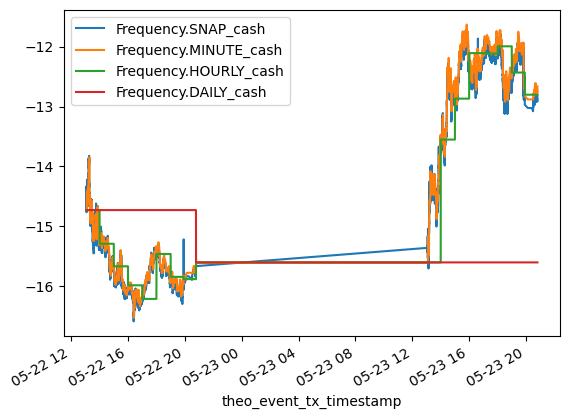

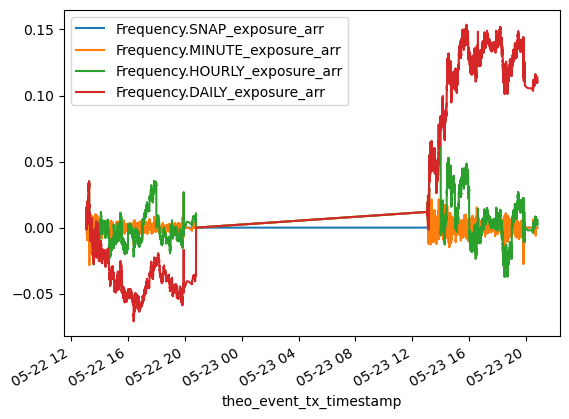

In [9]:
cls.data[['Frequency.SNAP_cash','Frequency.MINUTE_cash','Frequency.HOURLY_cash','Frequency.DAILY_cash']][:-1].plot()
cls.data[['Frequency.SNAP_exposure_arr','Frequency.MINUTE_exposure_arr','Frequency.HOURLY_exposure_arr','Frequency.DAILY_exposure_arr']][:-1].plot()